In [10]:
import os, sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('./s2spy')
from s2spy import rgdr, RGDR, time
import utils, plotting
path_obs_data = '~/data/volume_2/observational/'
path_subseasonal_data = '/data/volume_2/subseasonal/'

In [11]:
target = xr.open_dataarray(os.path.join(path_obs_data, 'preprocessed', 'chrips_tp_1981-2021_africa_aggregated_intervals.nc'))
target

<xarray.DataArray 'precip' (anchor_year: 41, target_period: 10, latitude: 79,
                            longitude: 72)>
[2332080 values with dtype=float32]
Coordinates:
  * anchor_year    (anchor_year) int64 1981 1982 1983 1984 ... 2019 2020 2021
  * target_period  (target_period) int64 0 1 2 3 4 5 6 7 8 9
  * longitude      (longitude) float64 33.12 33.38 33.62 ... 50.38 50.62 50.88
  * latitude       (latitude) float64 -4.625 -4.375 -4.125 ... 14.38 14.62 14.88
    target         bool ...

In [12]:
hoa_mask = xr.open_dataarray(os.path.join(path_obs_data, 'chirps_hoa_dry_mask_0.25deg.nc'))
target_timeseries = target.where(hoa_mask).mean(dim=('latitude', 'longitude'))

In [13]:
dfs = pd.read_hdf('/data/volume_2/subseasonal/ecmwf/aggregated/aggregation_timestamps.h5').sort_index()
df = dfs[['aggregation_start_inclusive', 'aggregation_end_inclusive']].copy()
sel_months = [10, 11, 12]
mon_start_mask = [True if m in sel_months else False for m in df.set_index('aggregation_start_inclusive').index.month]
mon_end_mask = [True if m in sel_months else False for m in df.set_index('aggregation_end_inclusive').index.month]
mon_mask = np.logical_and(mon_start_mask, mon_end_mask)
df_sub = dfs[mon_mask][dfs[mon_mask].index.year==dfs[mon_mask].index.year[0]]
anchor_dates = [(d.month, d.day) for d in df_sub.index]

In [14]:
anchor_date = anchor_dates[0]

In [15]:
cal = time.AdventCalendar(anchor=anchor_date, freq='30d', max_lag=3)
cal = cal.map_years(1981, 2021)

In [ ]:
sst_resampled = time.resample(cal, sst)
sst_resampled

Plotting Corr maps None, split 0, lag 0
Plotting Corr maps None, split 0, lag 0
Plotting Corr maps None, split 0, lag 0


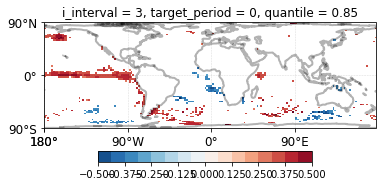

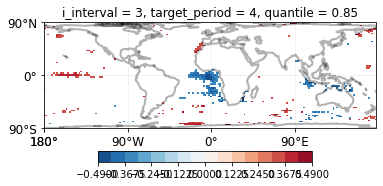

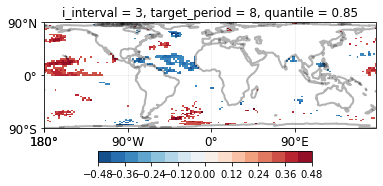

In [51]:
for period in target_timeseries.target_period.values[::4]:
    corr, pval = rgdr.rgdr.correlation(sst_resampled['sst'].sel(i_interval=3), target_timeseries.sel(target_period=int(period)),
                                       corr_dim='anchor_year')
    plotting.plot_maps(corr.where(pval < 0.05))

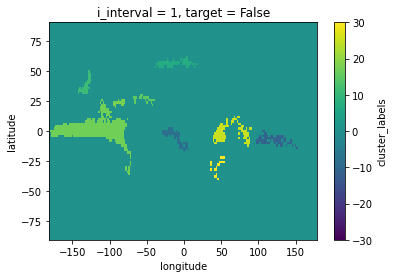

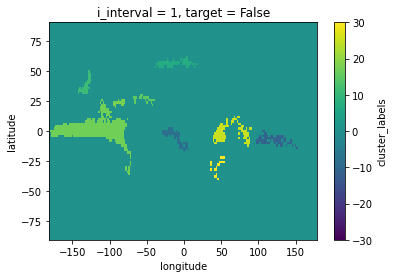

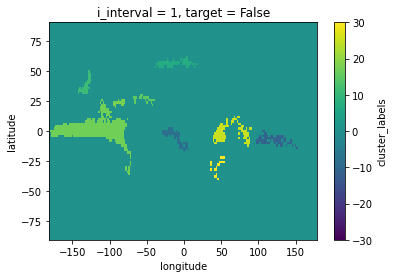

In [30]:
for period in target_timeseries.target_period.values[::4]:
    rg = RGDR(target_timeseries.sel(target_period=0), eps_km=600, alpha=0.05, min_area_km2=3000**2)
    rg.plot_clusters(sst_resampled['sst'].sel(i_interval=1))